## A pipeline in machine learning (ML) is a structured way to automate and organize workflows for data preprocessing, feature engineering, model training, evaluation, and deployment. It helps ensure consistency, reproducibility, and efficiency in ML workflows.

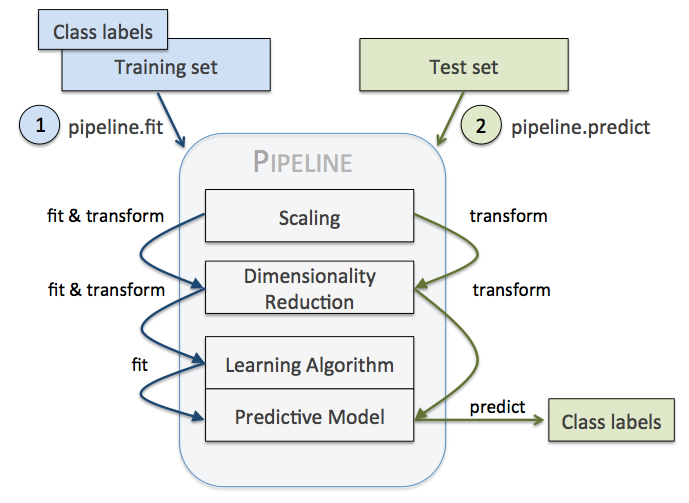

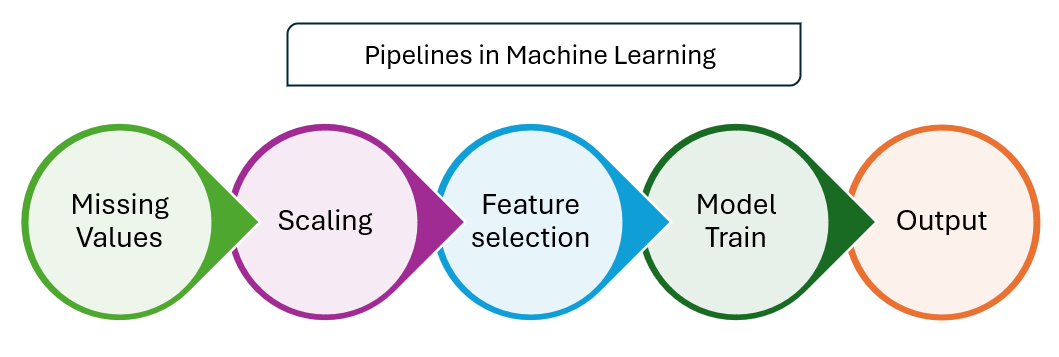

**pipelines automatically ensure that the same data transformations (preprocessing steps)** applied to the training data are also applied to the test data in the exact same way. Let me break it down further:

---

### Without a Pipeline:
You might need to preprocess your data manually in multiple steps. For example:
1. Scaling numerical features.
2. Encoding categorical features.
3. Applying these transformations to both **training** and **test** data.

Here’s where problems can arise:
- You might forget to apply a transformation to the test data.
- You could accidentally apply different transformations (e.g., using different scales or encoders).
- Errors like these could lead to **data leakage** or incorrect results.

---

### With a Pipeline:
When you build a pipeline, it combines all preprocessing steps and the model training step into a single workflow. Here's what happens:
1. During **training** (`fit`):
   - The pipeline learns from the training data (e.g., calculating scaling factors or fitting encoders).
   - It applies the transformations to the training data.

2. During **testing/prediction** (`predict` or `score`):
   - The pipeline automatically applies the **same transformations** to the test data, using the same parameters it learned during training (e.g., the same scaling factors).

This guarantees consistency.

---

### Example:
#### Without Pipeline:
```python
# Training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Testing
# Risk of forgetting to scale or using fit_transform instead of transform
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)
```

#### With Pipeline:
```python
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

pipeline.fit(X_train, y_train)  # Scales and trains in one step
predictions = pipeline.predict(X_test)  # Automatically scales test data
```

---

### Why This Matters:
- **Consistency**: Preprocessing on train and test data is always identical.
- **Simplicity**: You don’t need to remember or manually repeat the steps for the test data.
- **No Errors**: Prevents mistakes like using `fit_transform` on test data, which can cause data leakage. 

In [297]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

In [298]:
df = pd.read_csv("accident.csv")

In [299]:
df.sample(10)

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
180,62,Female,119.0,Yes,Yes,1
147,31,Female,83.0,Yes,Yes,0
151,32,Female,112.0,Yes,Yes,1
10,28,Female,88.0,No,Yes,1
107,61,Male,116.0,Yes,No,0
76,61,Male,39.0,Yes,Yes,0
91,35,Female,70.0,Yes,Yes,0
163,47,Female,66.0,Yes,Yes,0
161,49,Female,111.0,Yes,Yes,1
6,38,Male,116.0,Yes,Yes,1


In [300]:
df.shape

(200, 6)

In [301]:
df.isnull().sum()

Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64

In [302]:
X = df.drop("Survived", axis=1)

In [303]:
X

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used
0,56,Female,27.0,No,No
1,69,Female,46.0,No,Yes
2,46,Male,46.0,Yes,Yes
3,32,Male,117.0,No,Yes
4,60,Female,40.0,Yes,Yes
...,...,...,...,...,...
195,69,Female,111.0,No,Yes
196,30,Female,51.0,No,Yes
197,58,Male,110.0,No,Yes
198,20,Male,103.0,No,Yes


In [304]:
y = df["Survived"]

In [305]:
y

0      1
1      1
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: Survived, Length: 200, dtype: int64

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [307]:
X_train.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used
79,53,Male,35.0,Yes,No
197,58,Male,110.0,No,Yes
38,61,Female,106.0,Yes,Yes
24,38,Female,25.0,Yes,Yes
122,24,Male,32.0,No,No


In [308]:
X_train.shape

(160, 5)

In [309]:
y_train

79     0
197    1
38     0
24     0
122    1
      ..
106    1
14     0
92     1
179    0
102    1
Name: Survived, Length: 160, dtype: int64

In [310]:
# Define categorical and numerical columns
categorical_columns = ['Gender', 'Helmet_Used', 'Seatbelt_Used']
numerical_columns = ['Age', 'Speed_of_Impact']       

In [311]:
# Step 1: Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
    ('scaler', MinMaxScaler())                             # Scale numerical features
])

In [312]:
numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler())])

In [313]:
# Step 2: Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categories
])

In [314]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [315]:
# Step 3: Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

In [316]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Speed_of_Impact']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Gender', 'Helmet_Used', 'Seatbelt_Used'])])

In [248]:
# Step 4: Feature selection
feature_selector = SelectKBest(score_func=chi2, k='all')  # Start with all features

In [249]:
feature_selector

SelectKBest(k='all', score_func=<function chi2 at 0x0000013E0BBF1300>)

In [250]:
# Step 5: Classifier
classifier = RandomForestClassifier(random_state=42)

In [251]:
classifier

RandomForestClassifier(random_state=42)

In [252]:
# Step 6: Create the complete pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

In [253]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Speed_of_Impact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Helmet_Used',
                                                   'Seatbelt_Used'])])),
                ('feature_selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000013E0BBF1300>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [254]:
# Train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Speed_of_Impact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Helmet_Used',
                                                   'Seatbelt_Used'])])),
                ('feature_selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000013E0BBF1300>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [255]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('scaler', MinMaxScaler())]),
                                  ['Age', 'Speed_of_Impact']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_output=False))]),
                                  ['Gender', 'Helmet_Used', 'Seatbelt_Used'])]),
 'feature_selector': SelectKBest(k='all', score_func=<function chi2 at 0x0000013E0BBF1300>),
 'classifier': RandomForestClassi

In [256]:
from sklearn import set_config
set_config(display='diagram')

In [257]:
y_pred = pipeline.predict(X_test)

In [258]:
y_pred

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1], dtype=int64)

In [259]:
y_test

95     1
15     0
30     0
158    0
128    1
115    1
69     0
170    0
174    0
45     0
66     1
182    1
165    0
78     0
186    0
177    0
56     0
152    1
82     1
68     0
124    0
16     0
148    1
93     1
65     1
60     0
84     1
67     1
125    0
132    1
9      1
18     1
55     0
75     1
150    1
104    0
135    0
137    1
164    0
76     0
Name: Survived, dtype: int64

In [260]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.525

In [261]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()

0.4875

In [263]:
# export
import pickle
pickle.dump(pipeline, open('pipe.pkl', 'wb') )

In [264]:
pipe = pickle.load(open('pipe.pkl','rb'))

In [275]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Speed_of_Impact']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Helmet_Used',
                                                   'Seatbelt_Used'])])),
                ('feature_selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000013E0BBF1300>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [295]:
# Example test input (ensure these values match your dataset's columns)
test_input = pd.DataFrame({
    'Age': [28, 39],  # Example test ages
    'Gender': ['Female', 'Female'],  # Gender must match training values
    'Speed_of_Impact': [79.0, 113.0],  # Example speeds
    'Helmet_Used': ['No', 'No'],  # Helmet usage
    'Seatbelt_Used': ['Yes', 'No']  # Seatbelt usage
})

# Ensure columns in test_input match those in the training data
test_input = test_input[X_train.columns]

# Make predictions
predictions = pipe.predict(test_input)
print(predictions)

[0 1]


## Himel Sarder
## Dept. of CSE, JSTU